In [92]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

#%pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile
import GPUtil
import psutil
import time

2.17.0


In [93]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

# Shuffle the dataset
BUFFER_SIZE = int(1e4)  # You can adjust this size based on your memory and data size
ds = ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)
ds


<_ShuffleDataset element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), 

In [94]:
import tensorflow as tf

FEATURES = 28
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
ds = tf.data.experimental.CsvDataset(gz, [tf.float32]*(FEATURES+1), compression_type="GZIP")

# Shuffle the dataset
BUFFER_SIZE = int(1e4)
ds = ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)

# Split features and labels
ds = ds.map(lambda *x: (tf.stack(x[1:]), x[0]))

# Calculate the size of the dataset
# Defining parameters for NN
N_VALIDATION = int(1e4)
N_TRAIN = int(1e5)
BUFFER_SIZE = int(1e5)
#BATCH_SIZE = 500
dataset_size = BUFFER_SIZE

# Split into training and test datasets (80-20 split)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

ds_train = ds.take(train_size)
ds_val = ds.skip(train_size)

# Batch the datasets
BATCH_SIZE = 1024
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
ds_train = ds_train.batch(BATCH_SIZE)
ds_val = ds_val.batch(BATCH_SIZE)

# Normalize the features within the dataset
def normalize(x, y):
    x = tf.cast(x, tf.float32)
    x = x / 255.0  # Adjust this based on your specific data range
    return x, y

ds_train = ds_train.map(normalize)
ds_val = ds_val.map(normalize)

# One-hot encode the labels
def one_hot_encode(x, y):
    y = tf.one_hot(tf.cast(y, tf.int32), depth=2)  # 2 classes: 0 and 1
    return x, y

ds_train = ds_train.map(one_hot_encode)
ds_val = ds_val.map(one_hot_encode)

# Prefetch to improve performance
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

print(ds_train)
print(ds_val)

# Convert to tensors
X_train, y_train = next(iter(ds_train))
X_val, y_val = next(iter(ds_val))

# Now X_train, y_train, X_val, and y_val are ready for use
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
X_train shape: (1024, 28), y_train shape: (1024, 2)
X_val shape: (1024, 28), y_val shape: (1024, 2)


In [95]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [96]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

# TensorBoards have been shutdown since 1. January 2024

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    X_train,
    y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(name),
    verbose=0)
  return history

## Activations

- elu
- relu
- tanh

In [97]:
histories1 = {}

In [98]:
model_elu = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])

model_relu = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model_tanh = tf.keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=(FEATURES,)),
    layers.Dense(64, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(2, activation='softmax')
])

model_sigm = tf.keras.Sequential([
    layers.Dense(64, activation='sigmoid', input_shape=(FEATURES,)),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(2, activation='softmax')
])

c:\Programming\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [99]:
histories1['elu']  = compile_and_fit(model_elu, "activation/elu")
histories1['relu']  = compile_and_fit(model_relu, "activation/relu")
histories1['tanh']  = compile_and_fit(model_tanh, "activation/tanh")
histories1['sigm']  = compile_and_fit(model_sigm, "activation/sigm")

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)

c:\Programming\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



Epoch: 0, accuracy:0.5195,  binary_crossentropy:0.6935,  loss:0.6935,  val_accuracy:0.5078,  val_binary_crossentropy:0.6931,  val_loss:0.6931,  
.

c:\Programming\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


...................................................................................................
Epoch: 100, accuracy:0.6123,  binary_crossentropy:0.6430,  loss:0.6430,  val_accuracy:0.5752,  val_binary_crossentropy:0.6849,  val_loss:0.6849,  
....................................................................................................
Epoch: 200, accuracy:0.6445,  binary_crossentropy:0.6121,  loss:0.6121,  val_accuracy:0.6084,  val_binary_crossentropy:0.6909,  val_loss:0.6909,  
................................................................................

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5176,  binary_crossentropy:0.6931,  loss:0.6931,  val_accuracy:0.5078,  val_binary_crossentropy:0.6931,  val_loss:0.6931,  
....................................................................................................
Epoch: 100, accuracy:0.6406,  binary_crossentropy:0.6304,  loss:0.6304,  val_accuracy:0.5723,  val_binary_crossentropy:0.6730,  val_loss:0.6730,  
....................................................................................................
Epoch: 200, accuracy:0.6982,  binary_crossentropy:0.5627,  loss:0.5627,  val_accuracy:0.6162,  val_binary_crossentropy:0.6950,  val_loss:0.6950,  
....................................................................................................
Epoch: 300, accuracy:0.7500,  binary_crossentropy:0.4956,  loss:0.4956,  val_accuracy:0.5879,  val_binary_crossentropy:0.7936,  val_loss:0.7936,  
........................

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_106 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4922,  binary_crossentropy:0.6938,  loss:0.6938,  val_accuracy:0.5078,  val_binary_crossentropy:0.6932,  val_loss:0.6932,  
....................................................................................................
Epoch: 100, accuracy:0.6074,  binary_crossentropy:0.6528,  loss:0.6528,  val_accuracy:0.5840,  val_binary_crossentropy:0.6688,  val_loss:0.6688,  
....................................................................................................
Epoch: 200, accuracy:0.6084,  binary_crossentropy:0.6449,  loss:0.6449,  val_accuracy:0.6016,  val_binary_crossentropy:0.6651,  val_loss:0.6651,  
....................................................................................................
Epoch: 300, accuracy:0.6309,  binary_crossentropy:0.6088,  loss:0.6088,  val_accuracy:0.6084,  val_binary_crossentropy:0.6634,  val_loss:0.6634,  
....................................................................................................
Epoch: 40

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5029,  binary_crossentropy:0.6992,  loss:0.6992,  val_accuracy:0.5078,  val_binary_crossentropy:0.6931,  val_loss:0.6931,  
....................................................................................................
Epoch: 100, accuracy:0.5195,  binary_crossentropy:0.6934,  loss:0.6934,  val_accuracy:0.5078,  val_binary_crossentropy:0.6931,  val_loss:0.6931,  
....................................................................................................
Epoch: 200, accuracy:0.5020,  binary_crossentropy:0.6939,  loss:0.6939,  val_accuracy:0.5078,  val_binary_crossentropy:0.6931,  val_loss:0.6931,  
.........................

In [125]:
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

def plot_loss(size_histories):
    plt.figure(figsize=(10, 6))
    
    #for name, history in size_histories.items():
    #    plt.plot(history.history['loss'], label=f'{name} Loss')

    plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)

    plotter.plot(size_histories)

    #plt.xlim([0, max(plt.xlim())])
    #plt.ylim([0.5, 0.7])
    
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel("Epochs [Log Scale]")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss over Epochs')
    plt.show()

import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix


def plot_accuracy(size_histories, step):
    """
    Plots training and validation accuracy over epochs for multiple models.
    
    Args:
        size_histories (dict): Dictionary where keys are model names and values are TensorFlow History objects.
    """
    plt.figure(figsize=(12, 8))

    # Generate a color palette based on the number of models
    num_models = len(size_histories)
    colors = sns.color_palette("hsv", num_models)  # Using a seaborn color palette

    for i, (name, history) in enumerate(size_histories.items()):
        epochs = history.epoch[::step]
        acc = history.history['accuracy'][::step]
        val_acc = history.history['val_accuracy'][::step]

        plt.plot(epochs, acc, color=colors[i], label=f'{name} Training Accuracy')
        plt.plot(epochs, val_acc, linestyle="--", color=colors[i], label=f'{name} Validation Accuracy')
    
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(0, max(plt.ylim()))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_roc_curves(models, X_validation, y_validation, step):
    """
    Plots ROC curves for multiple models on the same figure.
    
    Args:
        models (dict): Dictionary where keys are model names and values are trained TensorFlow models.
        X_test (numpy.array): Test features.
        y_test (numpy.array): True binary labels for the test set.
    """
    plt.figure(figsize=(12, 8))
    
    for name, model in models.items():
        #y_pred_prob = model.predict(X_test).ravel()
        y_pred = model.predict(X_validation)[:, 1]  # Get predictions
        #y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_validation, axis=1)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        print(fpr)

        plt.plot(fpr[::step], tpr[::step], label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



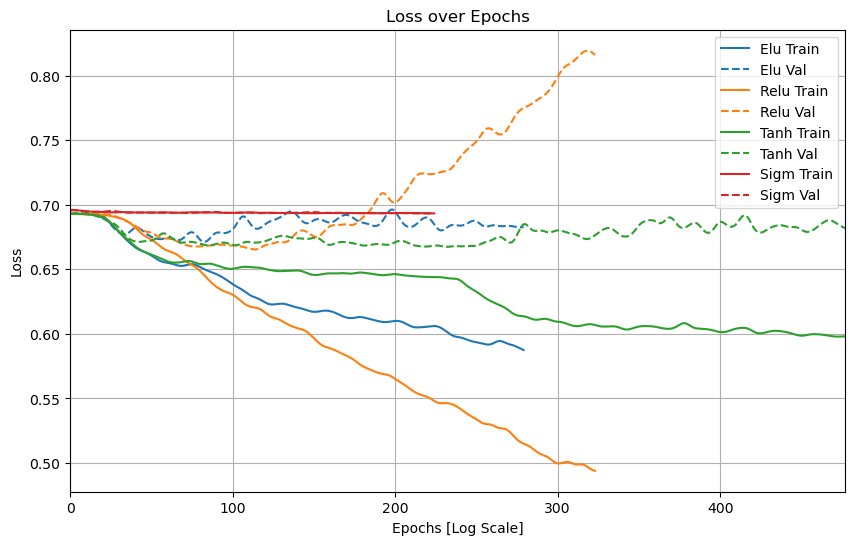

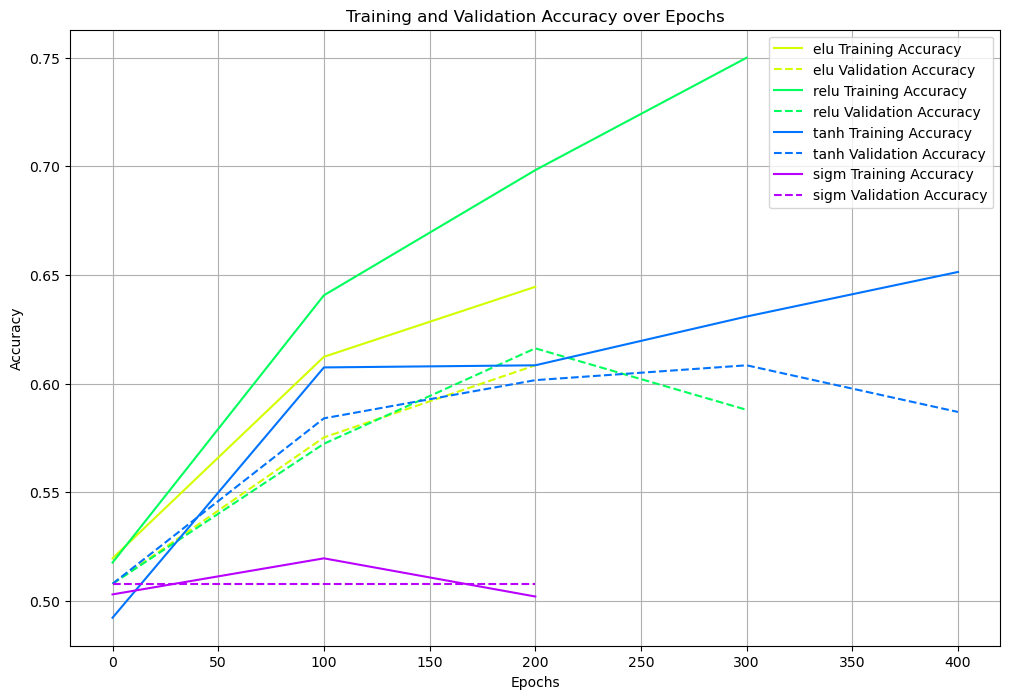

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
[0.00000000e+00 2.07727462e-04 2.07727462e-04 ... 9.99376818e-01
 9.99376818e-01 1.00000000e+00]
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
[0.00000000e+00 2.07727462e-04 2.07727462e-04 ... 9.99169090e-01
 9.99169090e-01 1.00000000e+00]
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
[0.00000000e+00 0.00000000e+00 2.07727462e-04 ... 9.97922725e-01
 9.97922725e-01 1.00000000e+00]
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
[0.00000000e+00 0.00000000e+00 2.07727462e-04 2.07727462e-04
 4.15454923e-04 4.15454923e-04 6.23182385e-04 8.30909846e-04
 8.30909846e-04 1.03863731e-03 1.03863731e-03 1.24636477e-03
 1.45409223e-03 1.86954715e-03 2.07727462e-03 2.07727462e-03
 2.49272954e-03 2.90818446e-03 3.11591192e-03 3.94682177e-03
 4.15454923e-03 6.02409639e-03 6.02409639e-03 7.06273369e-03
 8.72455339e-03 1.12172829e-02 1.28791026e-02 1.53718322e-02
 1.64104695e-02 1.86954715e-02 2.05650187e-02 2.36809306e-02
 2.78354799e-02 3.26132115e-02 3.69754882e-02 4.1

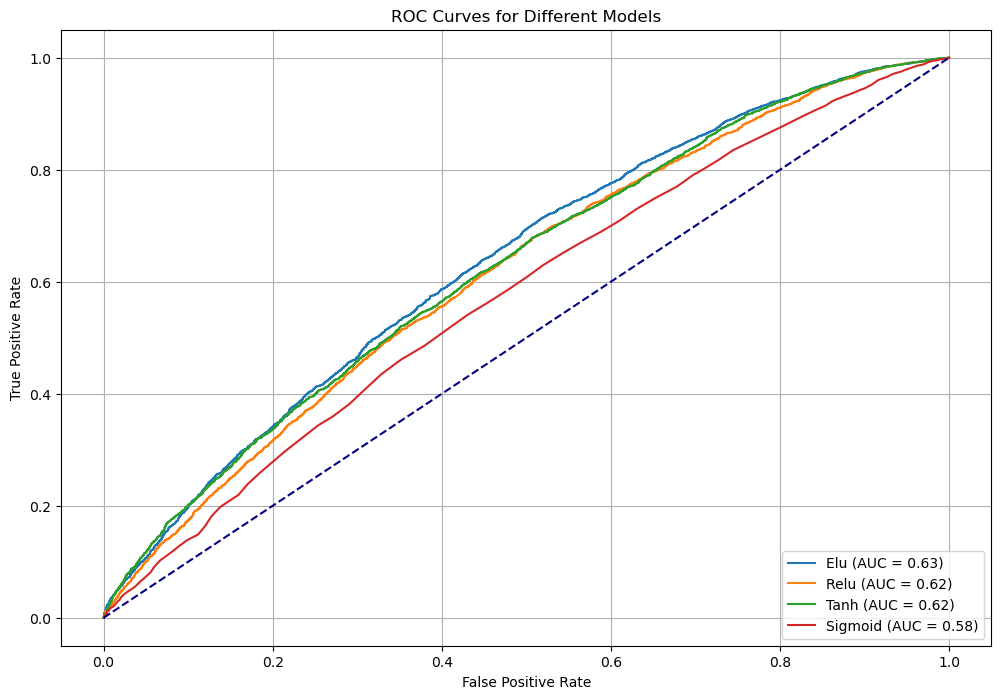

In [126]:
# Example usage:
# Assuming you have your models trained and histories saved
models = {
    'Elu': model_elu,
    'Relu': model_relu,
    'Tanh': model_tanh,
    'Sigmoid': model_sigm,
    # Add other models as needed
}

# And size_histories containing their training histories
plot_loss(histories1)
plot_accuracy(histories1, 100)
plot_roc_curves(models, X_val, y_val, 1)

In [102]:
def plot_prediction_histogram(model_key_name, models, X_validation, y_validation):
    """
    Plots histograms of the model's predicted probabilities for each class label.
    
    Args:
        model (tf.keras.Model): The trained model.
        validation_data (tf.data.Dataset): The validation dataset.
    """
    #X_train_sig = X_validation[:, 1]
    #X_train_bac = X_validation[:, 0]
    #y_pred_sig = model.predict(X_train_sig)
    #y_pred_bac = model.predict(X_train_bac)
    model = models[model_key_name]
    y_pred = model.predict(X_validation)
    y_pred_sig = y_pred[:, 1]
    y_pred_bac = y_pred[:, 0]

    proba_class_1 = y_pred_sig
    proba_class_2 = y_pred_bac

    # Plot histograms
    plt.figure(figsize=(12, 6))
    
    # Histogram for class 1 probabilities
    plt.hist(proba_class_1, bins=50, density=True, histtype='step', color='blue', alpha=0.9, linewidth=3, label='Signal')
    plt.hist(proba_class_2, bins=50, density=True, histtype='step', color='orange', alpha=0.9, linewidth=3, label='Background')
    
    # Optional: Add a histogram for class 0 probabilities
    # Uncomment if you need to visualize the class 0 probabilities as well
    # proba_class_0 = y_pred_proba[:, 0]
    # plt.hist(proba_class_0, bins=30, color='blue', alpha=0.7, label='Class 0 Probability')
    
    # Adding titles and labels
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Model Predictions {model_key_name}')
    plt.legend()
    
    plt.grid(True)
    plt.show()

#plot_prediction_histogram(models['Relu'], X_val, y_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


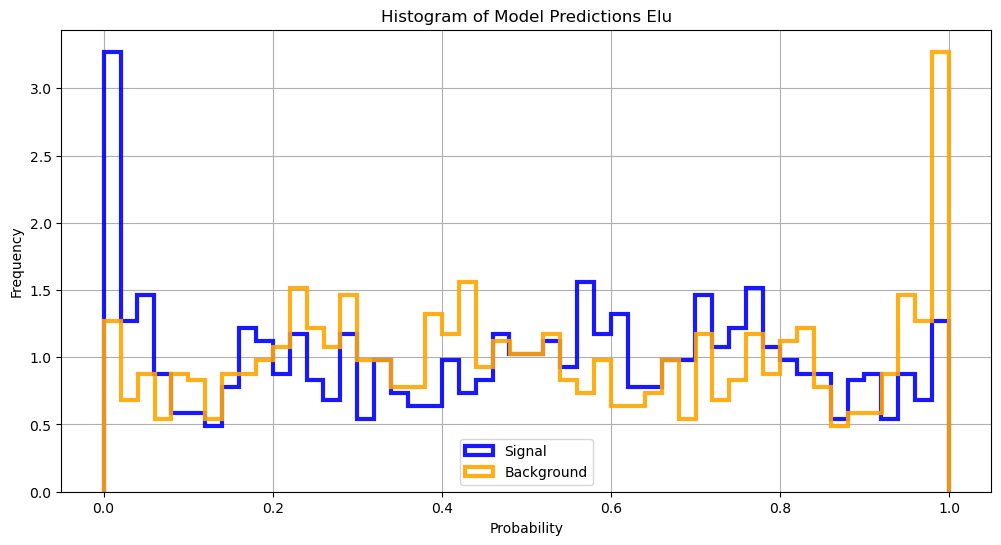

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


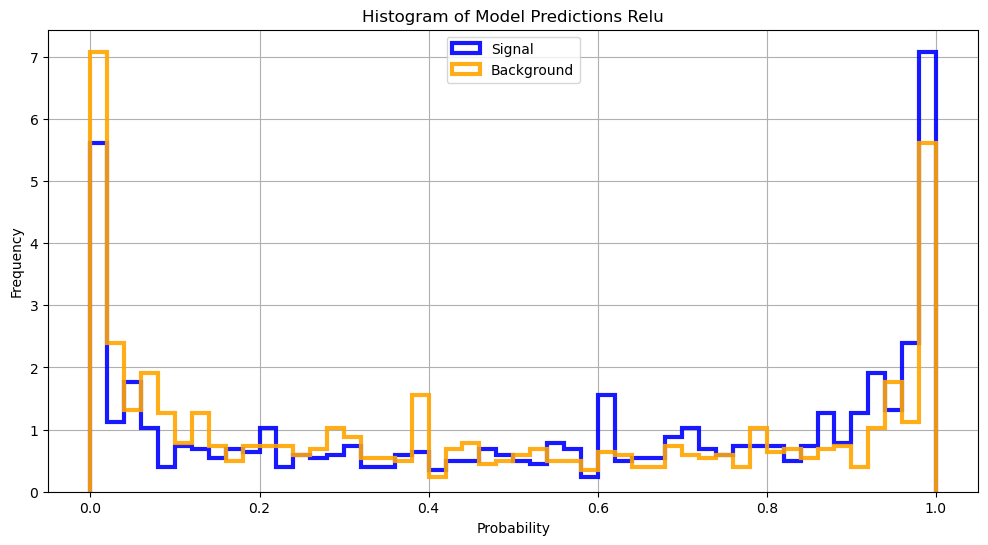

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


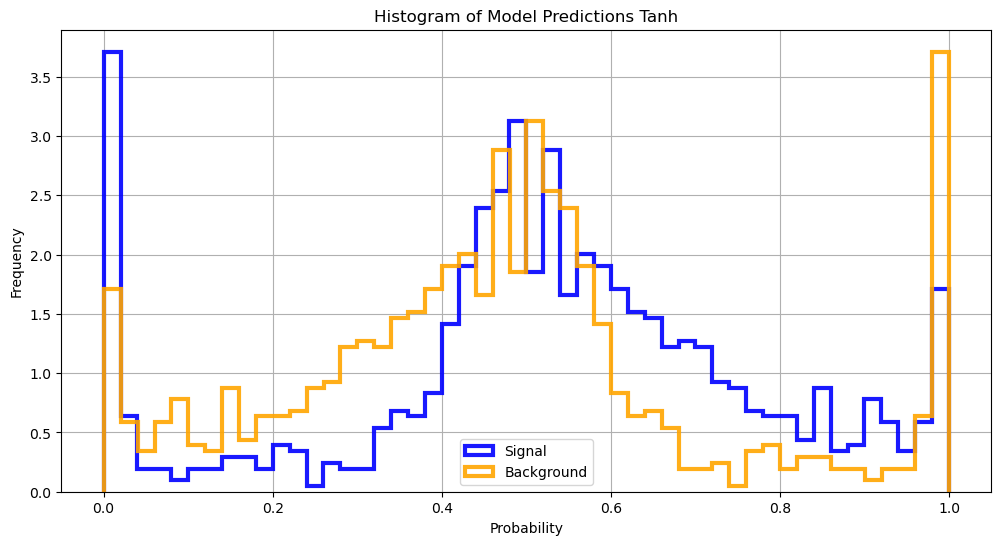

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


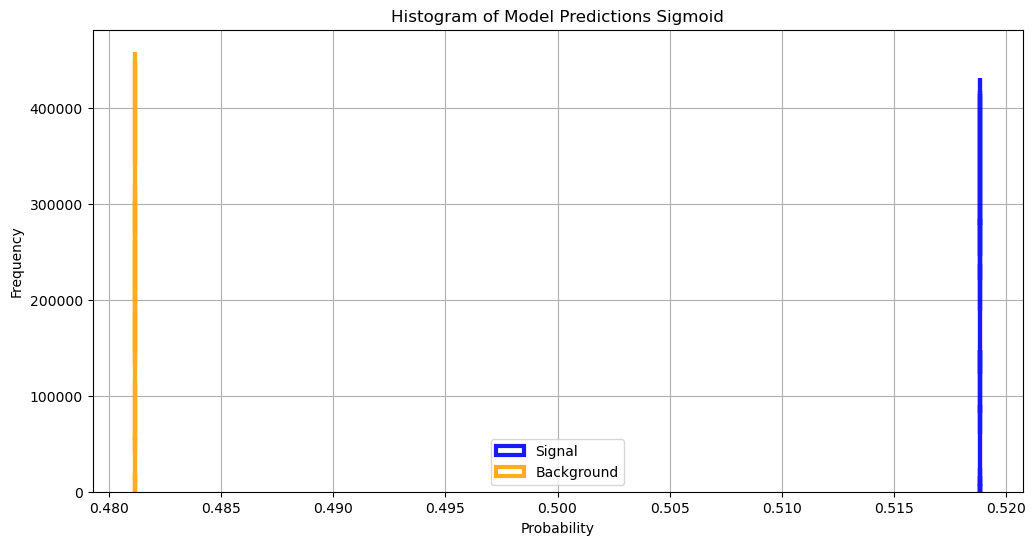

In [103]:
plot_prediction_histogram('Elu', models, X_val, y_val)
plot_prediction_histogram('Relu', models, X_val, y_val)
plot_prediction_histogram('Tanh', models, X_val, y_val)
plot_prediction_histogram('Sigmoid', models, X_val, y_val)

## Optimizers

- SGD
- Adam
- AdamW
- FTRL

In [104]:
histories2 = {}

In [105]:
model_adam = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])

model_adamw = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])

model_sgd = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])

model_ftrl = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])


c:\Programming\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [106]:
histories2['Adam']  = compile_and_fit(model_adam, "optimizer/adam", optimizer=tf.keras.optimizers.Adam(lr_schedule))
histories2['AdamW']  = compile_and_fit(model_adamw, "optimizer/adamw", optimizer=tf.keras.optimizers.AdamW(lr_schedule))
histories2['SGD']  = compile_and_fit(model_sgd, "optimizer/sgd", optimizer=tf.keras.optimizers.SGD(lr_schedule))
histories2['FTRL']  = compile_and_fit(model_ftrl, "optimizer/ftrl", optimizer=tf.keras.optimizers.Ftrl(lr_schedule))

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)

c:\Programming\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
c:\Programming\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch: 0, accuracy:0.4932,  binary_crossentropy:0.6937,  loss:0.6937,  val_accuracy:0.5078,  val_binary_crossentropy:0.6936,  val_loss:0.6936,  
....................................................................................................
Epoch: 100, accuracy:0.6055,  binary_crossentropy:0.6259,  loss:0.6259,  val_accuracy:0.6016,  val_binary_crossentropy:0.6889,  val_loss:0.6889,  
....................................................................................................
Epoch: 200, accuracy:0.6484,  binary_crossentropy:0.6031,  loss:0.6031,  val_accuracy:0.6172,  val_binary_crossentropy:0.6787,  val_loss:0.6787,  
...........................................................................

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_118 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4912,  binary_crossentropy:0.6944,  loss:0.6944,  val_accuracy:0.5078,  val_binary_crossentropy:0.6943,  val_loss:0.6943,  
....................................................................................................
Epoch: 100, accuracy:0.6133,  binary_crossentropy:0.6317,  loss:0.6317,  val_accuracy:0.5898,  val_binary_crossentropy:0.6947,  val_loss:0.6947,  
....................................................................................................
Epoch: 200, accuracy:0.6543,  binary_crossentropy:0.6086,  loss:0.6086,  val_accuracy:0.6172,  val_binary_crossentropy:0.6864,  val_loss:0.6864,  
...........................................................................................

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5195,  binary_crossentropy:0.6930,  loss:0.6930,  val_accuracy:0.5078,  val_binary_crossentropy:0.6930,  val_loss:0.6930,  
....................................................................................................
Epoch: 100, accuracy:0.5195,  binary_crossentropy:0.6924,  loss:0.6924,  val_accuracy:0.5078,  val_binary_crossentropy:0.6932,  val_loss:0.6932,  
....................................................................................................
Epoch: 200, accuracy:0.5195,  binary_crossentropy:0.6924,  loss:0.6924,  val_accuracy:0.5078,  val_binary_crossentropy:0.6933,  val_loss:0.6933,  
........

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5117,  binary_crossentropy:0.6931,  loss:0.6931,  val_accuracy:0.5078,  val_binary_crossentropy:0.6931,  val_loss:0.6931,  
....................................................................................................
Epoch: 100, accuracy:0.5195,  binary_crossentropy:0.6928,  loss:0.6928,  val_accuracy:0.5078,  val_binary_crossentropy:0.6930,  val_loss:0.6930,  
....................................................................................................
Epoch: 200, accuracy:0.5195,  binary_crossentropy:0.6928,  loss:0.6928,  val_accuracy:0.5078,  val_binary_crossentropy:0.6930,  val_loss:0.6930,  
....................................................................................................
Epoch: 300, accuracy:0.5195,  binary_crossentropy:0.6927,  loss:0.6927,  val_accuracy:0.5078,  val_binary_crossentropy:0.6930,  val_loss:0.6930,  
....................................................................................................
Epoch: 40

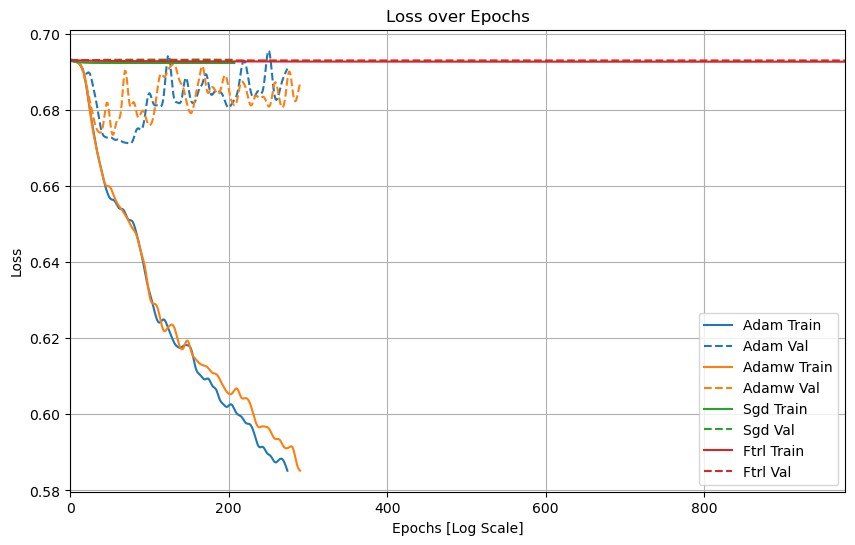

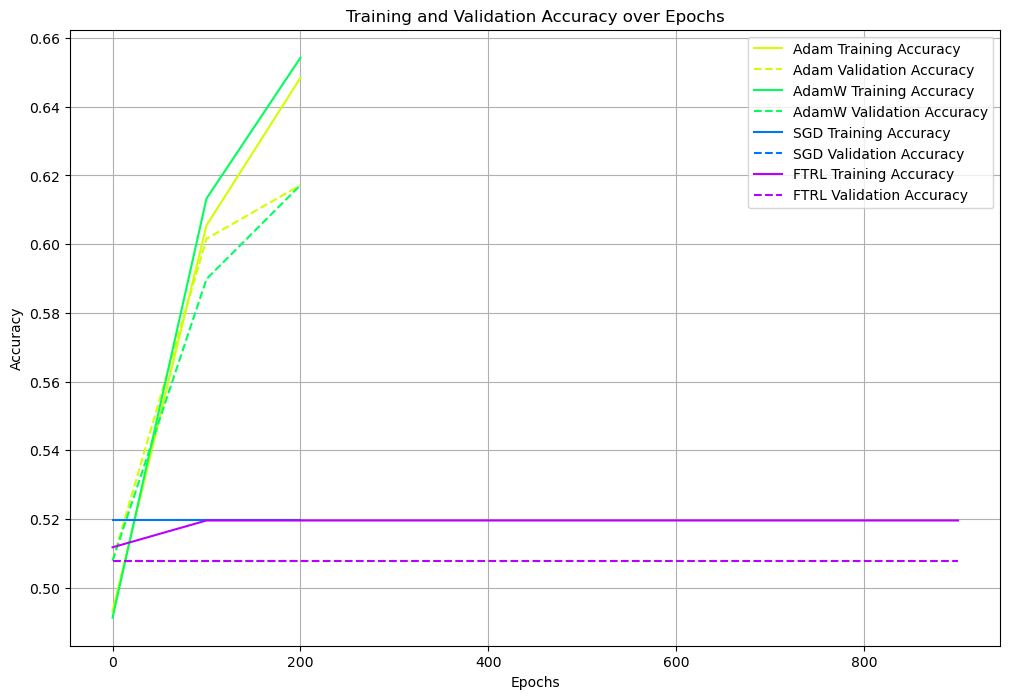

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
[0.00000000e+00 2.07727462e-04 4.15454923e-04 ... 9.99584545e-01
 9.99584545e-01 1.00000000e+00]
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
[0.00000000e+00 2.07727462e-04 2.07727462e-04 ... 9.99584545e-01
 9.99584545e-01 1.00000000e+00]
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
[0.00000000e+00 0.00000000e+00 2.07727462e-04 ... 9.99169090e-01
 1.00000000e+00 1.00000000e+00]
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
[0. 1.]


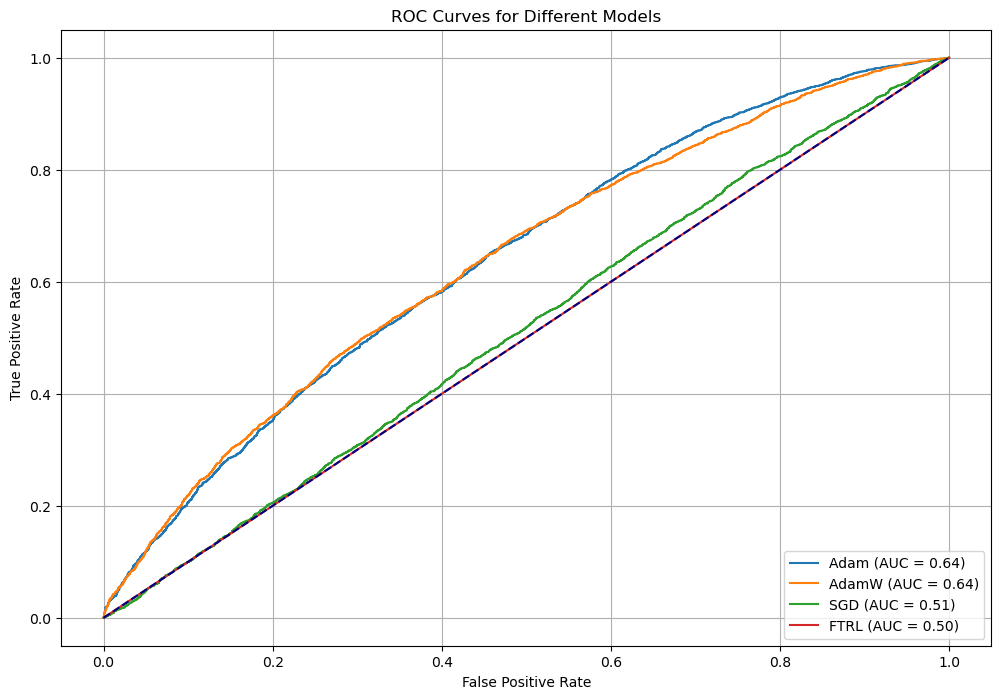

In [127]:
# Example usage:
# Assuming you have your models trained and histories saved
models2 = {
    'Adam': model_adam,
    'AdamW': model_adamw,
    'SGD': model_sgd,
    'FTRL': model_ftrl,
    # Add other models as needed
}

# And size_histories containing their training histories
plot_loss(histories2)
plot_accuracy(histories2, 100)
plot_roc_curves(models2, X_val, y_val, 1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


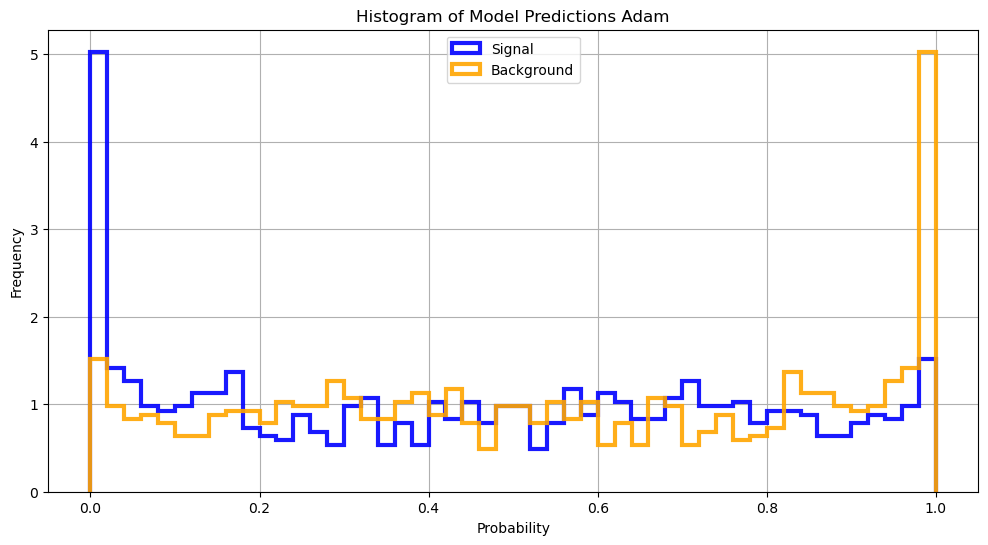

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


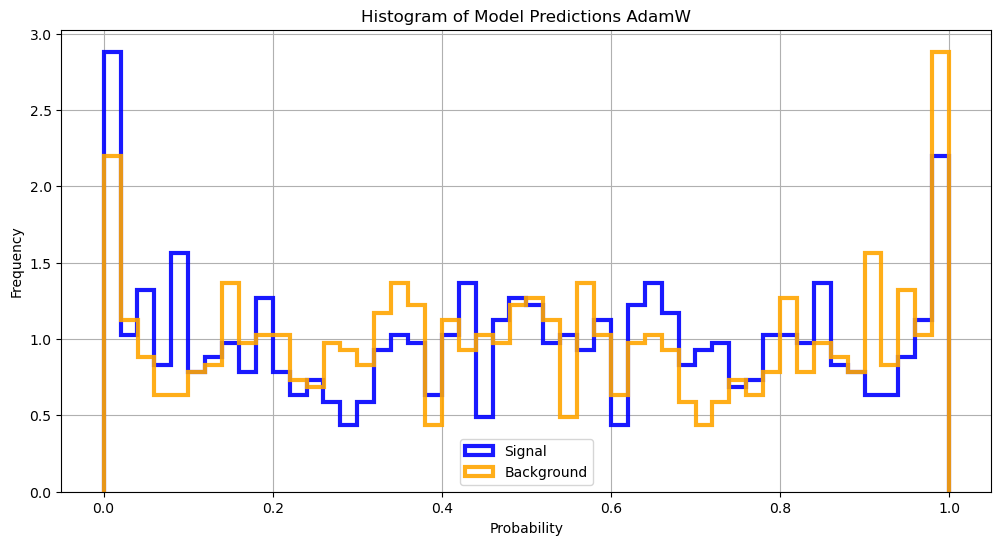

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


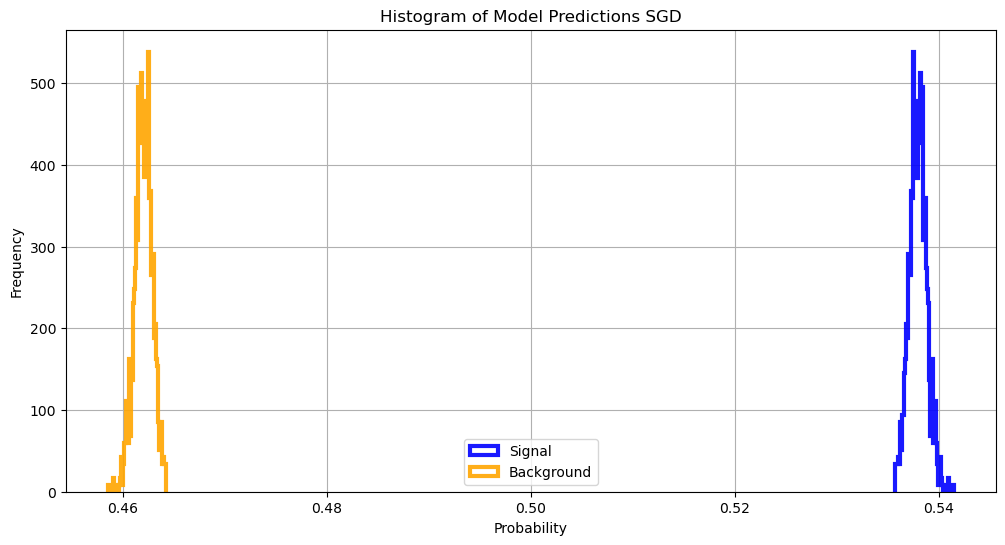

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


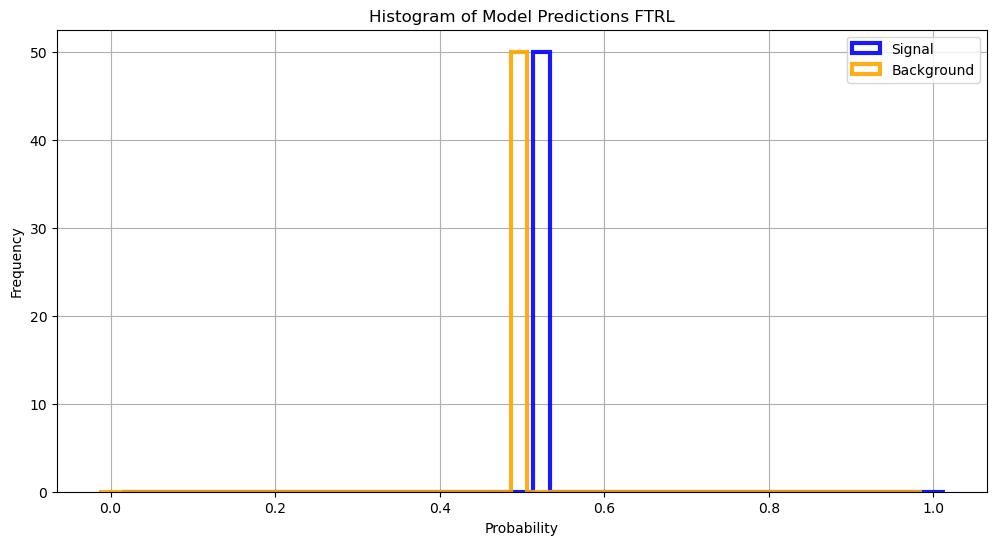

In [108]:
plot_prediction_histogram('Adam', models2, X_val, y_val)
plot_prediction_histogram('AdamW', models2, X_val, y_val)
plot_prediction_histogram('SGD', models2, X_val, y_val)
plot_prediction_histogram('FTRL', models2, X_val, y_val)

## Low vs High vs All

In [109]:
import tensorflow as tf

# Assuming the rest of your code is unchanged and X_train and X_val are ready
# Assuming FEATURES = 28

# Function to extract low and high-level features
def extract_low_high_features(x, y):
    x_low = x[:, :21]    # First 21 columns/features
    x_high = x[:, 21:28] # Columns 22 to 28
    return x, x_low, x_high, y

# Modify the dataset pipeline to extract the low and high-level features
ds_train_low_high = ds_train.map(lambda x, y: extract_low_high_features(x, y))
ds_val_low_high = ds_val.map(lambda x, y: extract_low_high_features(x, y))

# Unpack the datasets into different variables
X_train_full, X_train_low, X_train_high, y_train = next(iter(ds_train_low_high))
X_val_full, X_val_low, X_val_high, y_val = next(iter(ds_val_low_high))

# Now X_train_low, X_train_high, X_val_low, and X_val_high are ready for use
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_train_low shape: {X_train_low.shape}, X_train_high shape: {X_train_high.shape}")
print(f"X_val_low shape: {X_val_low.shape}, X_val_high shape: {X_val_high.shape}")


X_train shape: (1024, 28), y_train shape: (1024, 2)
X_val shape: (1024, 28), y_val shape: (1024, 2)
X_train_low shape: (1024, 21), X_train_high shape: (1024, 7)
X_val_low shape: (1024, 21), X_val_high shape: (1024, 7)


In [110]:
def compile_and_fit_lowhigh(model, name, X_train, y_train, X_val, y_val, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    X_train,
    y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [111]:
histories_lowhigh = {}

In [112]:
model_low= tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(X_train_low.shape[1],)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])

model_high = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(X_train_high.shape[1],)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])

model_full = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(X_train_full.shape[1],)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])

c:\Programming\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
histories_lowhigh['low']  = compile_and_fit_lowhigh(model_low, "features/low", X_train_low, y_train, X_val_low, y_val)
histories_lowhigh['high']  = compile_and_fit_lowhigh(model_high, "features/high", X_train_high, y_train, X_val_high, y_val)
histories_lowhigh['full']  = compile_and_fit_lowhigh(model_full, "features/full", X_train_full, y_train, X_val_full, y_val)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_130 (Dense)               │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,858 (38.51 KB)

 Trainable params: 9,858 (38.51 KB)

 Non-trainable params: 0 (0.00 B)

c:\Programming\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
c:\Programming\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch: 0, accuracy:0.5127,  binary_crossentropy:0.6929,  loss:0.6929,  val_accuracy:0.5303,  val_binary_crossentropy:0.6914,  val_loss:0.6914,  
....................................................................................................
Epoch: 100, accuracy:0.5664,  binary_crossentropy:0.6744,  loss:0.6744,  val_accuracy:0.5518,  val_binary_crossentropy:0.6927,  val_loss:0.6927,  
....................................................................................................
Epoch: 200, accuracy:0.6064,  binary_crossentropy:0.6572,  loss:0.6572,  val_accuracy:0.5469,  val_binary_crossentropy:0.7059,  val_loss:0.7059,  
....................................................................................................
Epoch: 300, accuracy:0.6152,  binary_crossentropy:0.6496,  loss:0.6496,  val_accuracy:0.5635,  val_binary_crossentropy:0.7031,  val_loss:0.7031,  
.......

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_134 (Dense)               │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,962 (35.01 KB)

 Trainable params: 8,962 (35.01 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5303,  binary_crossentropy:0.6920,  loss:0.6920,  val_accuracy:0.4697,  val_binary_crossentropy:0.6938,  val_loss:0.6938,  
....................................................................................................
Epoch: 100, accuracy:0.5801,  binary_crossentropy:0.6759,  loss:0.6759,  val_accuracy:0.5801,  val_binary_crossentropy:0.6710,  val_loss:0.6710,  
....................................................................................................
Epoch: 200, accuracy:0.5957,  binary_crossentropy:0.6658,  loss:0.6658,  val_accuracy:0.6074,  val_binary_crossentropy:0.6498,  val_loss:0.6498,  
....................................................................................................
Epoch: 300, accuracy:0.5957,  binary_crossentropy:0.6662,  loss:0.6662,  val_accuracy:0.6045,  val_binary_crossentropy:0.6480,  val_loss:0.6480,  
....................................................................................................
Epoch: 40

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_138 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5020,  binary_crossentropy:0.6940,  loss:0.6940,  val_accuracy:0.4717,  val_binary_crossentropy:0.6932,  val_loss:0.6932,  
....................................................................................................
Epoch: 100, accuracy:0.6182,  binary_crossentropy:0.6519,  loss:0.6519,  val_accuracy:0.5850,  val_binary_crossentropy:0.6820,  val_loss:0.6820,  
....................................................................................................
Epoch: 200, accuracy:0.6260,  binary_crossentropy:0.6286,  loss:0.6286,  val_accuracy:0.5996,  val_binary_crossentropy:0.6679,  val_loss:0.6679,  
....................................................................................................
Epoch: 300, accuracy:0.6504,  binary_crossentropy:0.6122,  loss:0.6122,  val_accuracy:0.5879,  val_binary_crossentropy:0.6732,  val_loss:0.6732,  
............................

In [114]:
def plot_roc_curves_lowhigh(models, X_vals, y_validation, step):
    """
    Plots ROC curves for multiple models on the same figure.
    
    Args:
        models (dict): Dictionary where keys are model names and values are trained TensorFlow models.
        X_test (numpy.array): Test features.
        y_test (numpy.array): True binary labels for the test set.
    """
    plt.figure(figsize=(12, 8))
    
    for i, (name, model) in enumerate(models.items()):
        #y_pred_prob = model.predict(X_test).ravel()
        y_pred = model.predict(X_vals[i])[:, 1]  # Get predictions
        #y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_validation, axis=1)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        #print(fpr)

        plt.plot(fpr[::step], tpr[::step], label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

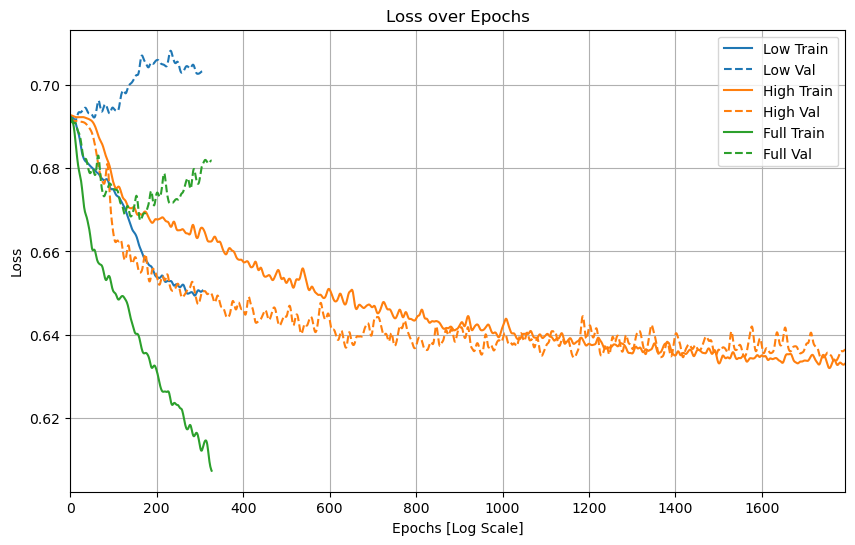

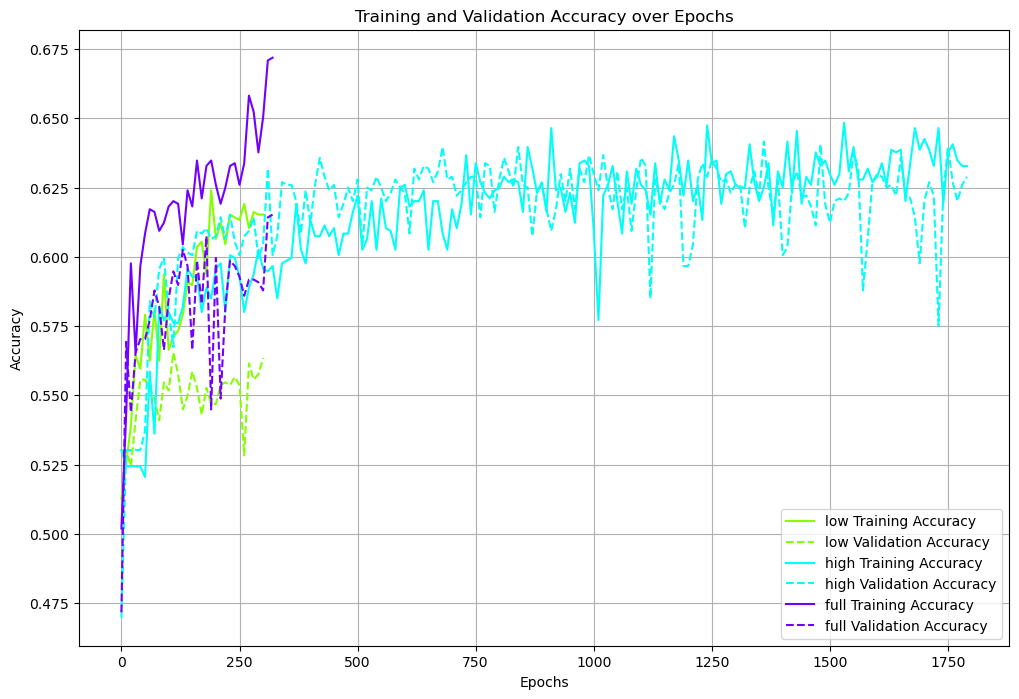

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


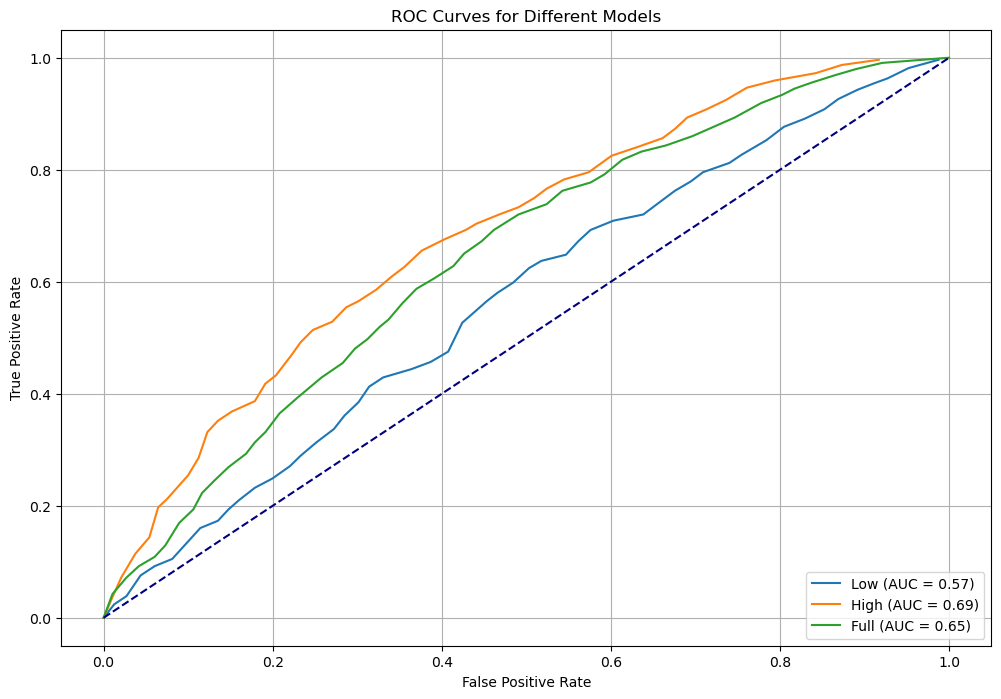

In [115]:
# Example usage:
# Assuming you have your models trained and histories saved
models_lowhigh = {
    'Low': model_low,
    'High': model_high,
    'Full': model_full,
}

# And size_histories containing their training histories
plot_loss(histories_lowhigh)
plot_accuracy(histories_lowhigh, 10)
plot_roc_curves_lowhigh(models_lowhigh, [X_val_low, X_val_high, X_val_full], y_val, 10)


In [116]:
def plot_prediction_histogram_lowhigh(model_key_name, models, X_validation, y_validation):
    """
    Plots histograms of the model's predicted probabilities for each class label.
    
    Args:
        model (tf.keras.Model): The trained model.
        validation_data (tf.data.Dataset): The validation dataset.
    """
    #X_train_sig = X_validation[:, 1]
    #X_train_bac = X_validation[:, 0]
    #y_pred_sig = model.predict(X_train_sig)
    #y_pred_bac = model.predict(X_train_bac)
    model = models[model_key_name]
    y_pred = model.predict(X_validation)
    y_pred_sig = y_pred[:, 1]
    y_pred_bac = y_pred[:, 0]

    proba_class_1 = y_pred_sig
    proba_class_2 = y_pred_bac

    # Plot histograms
    plt.figure(figsize=(12, 6))
    
    # Histogram for class 1 probabilities
    plt.hist(proba_class_1, bins=50, density=True, histtype='step', color='blue', alpha=0.9, linewidth=3, label='Signal')
    plt.hist(proba_class_2, bins=50, density=True, histtype='step', color='red', alpha=0.9, linewidth=3, label='Background')
    
    # Optional: Add a histogram for class 0 probabilities
    # Uncomment if you need to visualize the class 0 probabilities as well
    # proba_class_0 = y_pred_proba[:, 0]
    # plt.hist(proba_class_0, bins=30, color='blue', alpha=0.7, label='Class 0 Probability')
    
    # Adding titles and labels
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Model Predictions {model_key_name}')
    plt.legend()
    
    plt.grid(True)
    plt.show()

#plot_prediction_histogram(models['Relu'], X_val, y_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


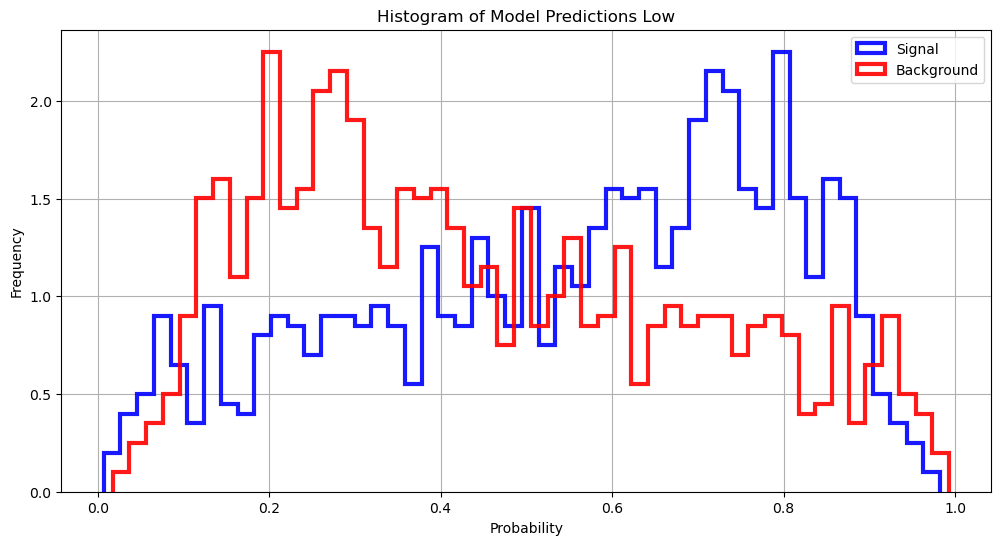

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


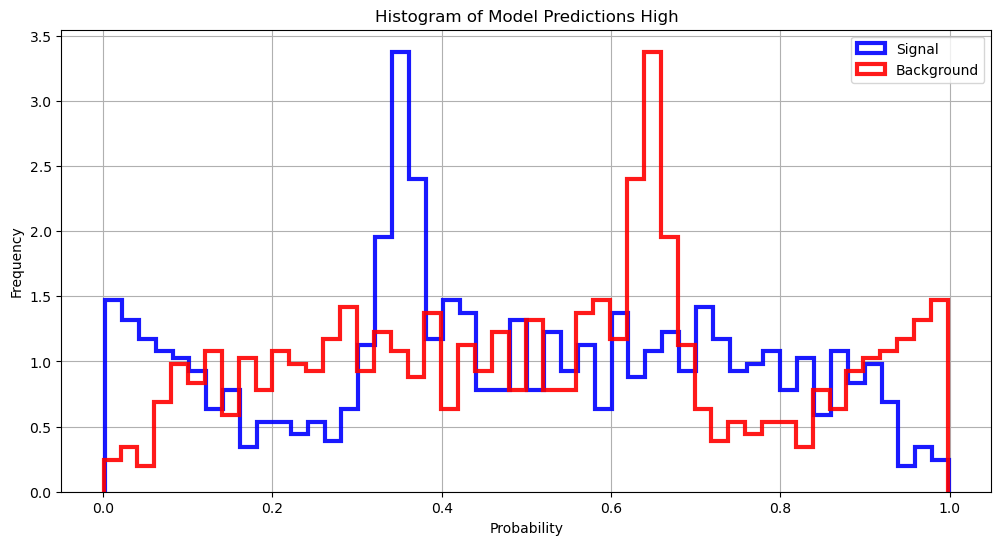

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


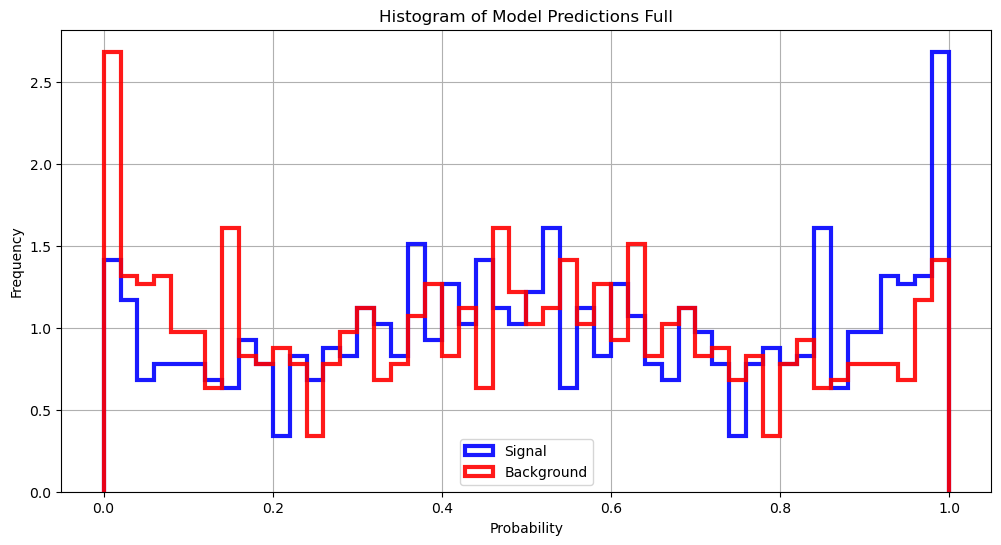

In [117]:
plot_prediction_histogram_lowhigh('Low', models_lowhigh, X_val_low, y_val)
plot_prediction_histogram_lowhigh('High', models_lowhigh, X_val_high, y_val)
plot_prediction_histogram_lowhigh('Full', models_lowhigh, X_val_full, y_val)

## Optimal

In [118]:
import tensorflow as tf

FEATURES = 28
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
ds = tf.data.experimental.CsvDataset(gz, [tf.float32]*(FEATURES+1), compression_type="GZIP")

# Shuffle the dataset
BUFFER_SIZE = int(1e4)
ds = ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)

# Split features and labels
ds = ds.map(lambda *x: (tf.stack(x[1:]), x[0]))

# Calculate the size of the dataset
# Defining parameters for NN
N_VALIDATION = int(1e4)
N_TRAIN = int(1e5)
BUFFER_SIZE = int(1e5)
#BATCH_SIZE = 500
dataset_size = BUFFER_SIZE

# Split into training and test datasets (80-20 split)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

ds_train = ds.take(train_size)
ds_val = ds.skip(train_size)

# Batch the datasets
#BATCH_SIZE = 1024
BATCH_SIZE = int(1e4)
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
ds_train = ds_train.batch(BATCH_SIZE)
ds_val = ds_val.batch(BATCH_SIZE)

# Normalize the features within the dataset
def normalize(x, y):
    x = tf.cast(x, tf.float32)
    x = x / 255.0  # Adjust this based on your specific data range
    return x, y

ds_train = ds_train.map(normalize)
ds_val = ds_val.map(normalize)

# One-hot encode the labels
def one_hot_encode(x, y):
    y = tf.one_hot(tf.cast(y, tf.int32), depth=2)  # 2 classes: 0 and 1
    return x, y

ds_train = ds_train.map(one_hot_encode)
ds_val = ds_val.map(one_hot_encode)

# Repeat dataset to ensure enough data for the number of epochs
ds_train = ds_train.repeat()  # Repeat indefinitely
ds_val = ds_val.repeat()      # Repeat indefinitely

# Prefetch to improve performance
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

print(ds_train)
print(ds_val)

# Convert to tensors
X_train, y_train = next(iter(ds_train))
X_val, y_val = next(iter(ds_val))

# Now X_train, y_train, X_val, and y_val are ready for use
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
X_train shape: (10000, 28), y_train shape: (10000, 2)
X_val shape: (10000, 28), y_val shape: (10000, 2)


In [119]:
history_optimal = {}

In [120]:
model_opt = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='elu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

history_optimal['optimal']  = compile_and_fit_lowhigh(model_opt, "optimal", X_train_full, y_train, X_val_full, y_val, optimizer=tf.keras.optimizers.AdamW(lr_schedule))

c:\Programming\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_142 (Dense)               │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,146 (24.01 KB)

 Trainable params: 6,146 (24.01 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1024
'y' sizes: 10000


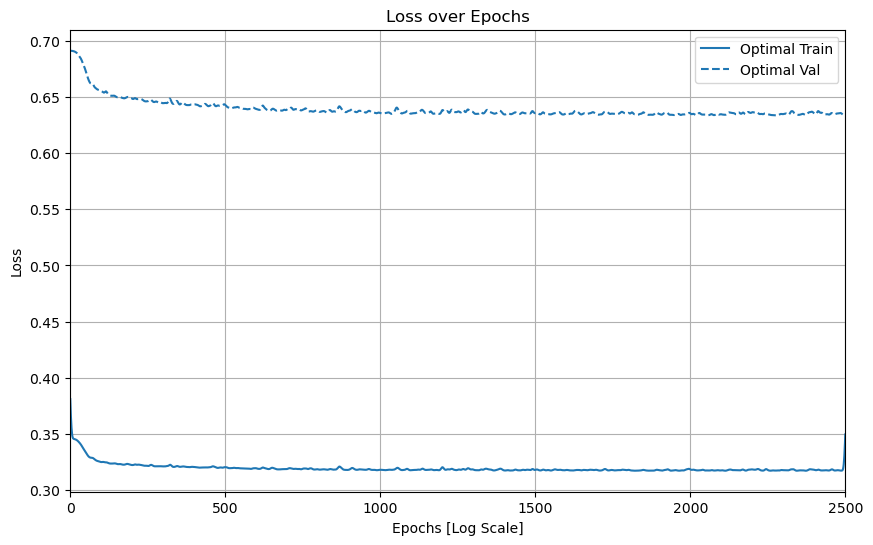

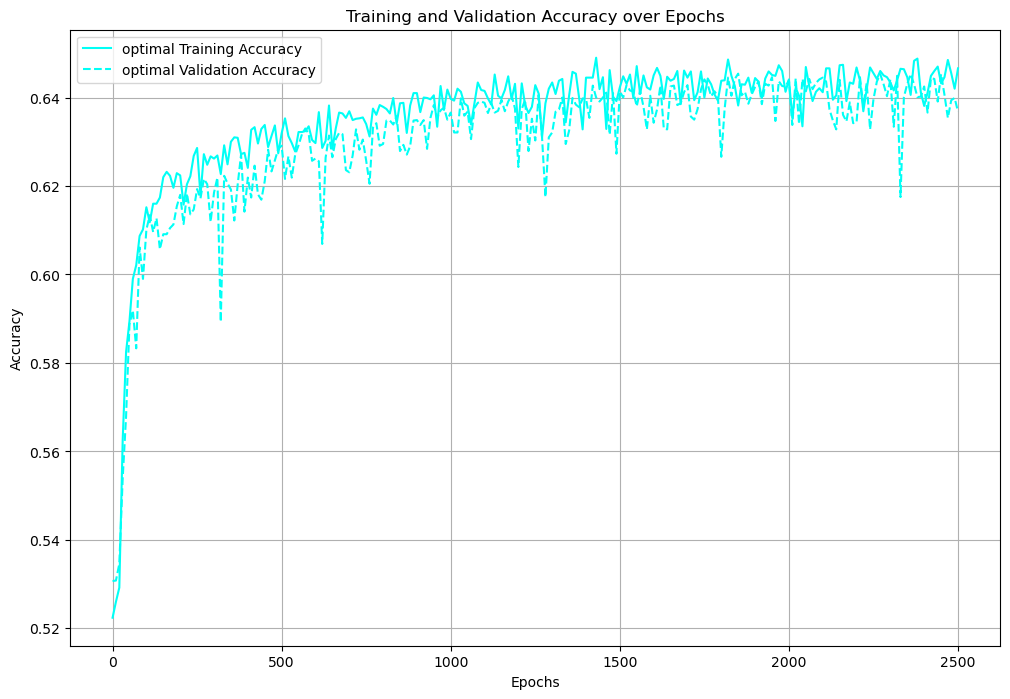

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


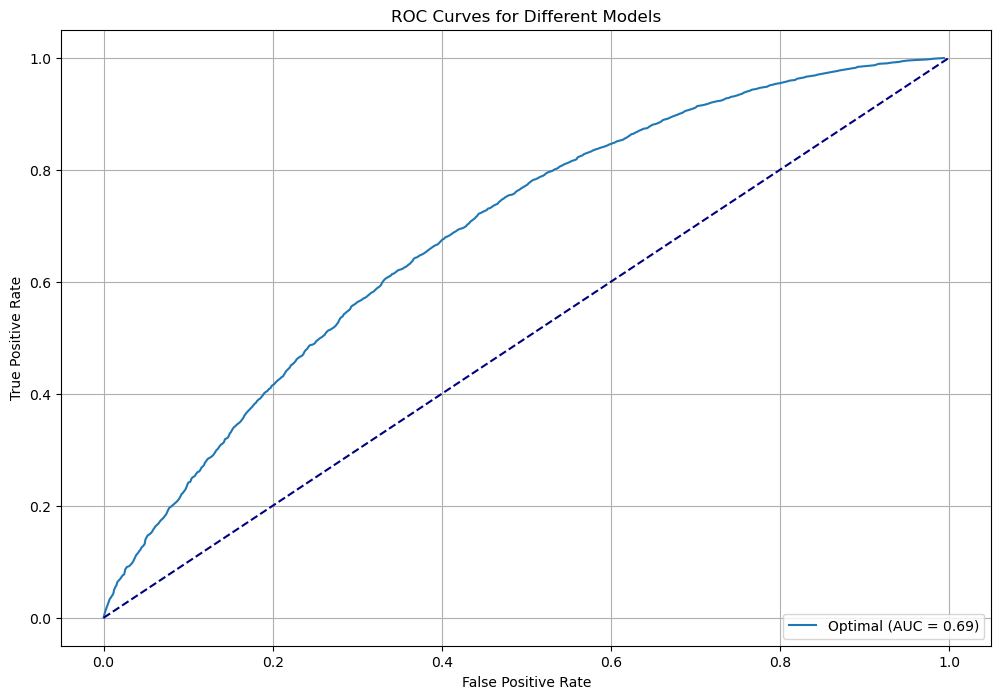

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


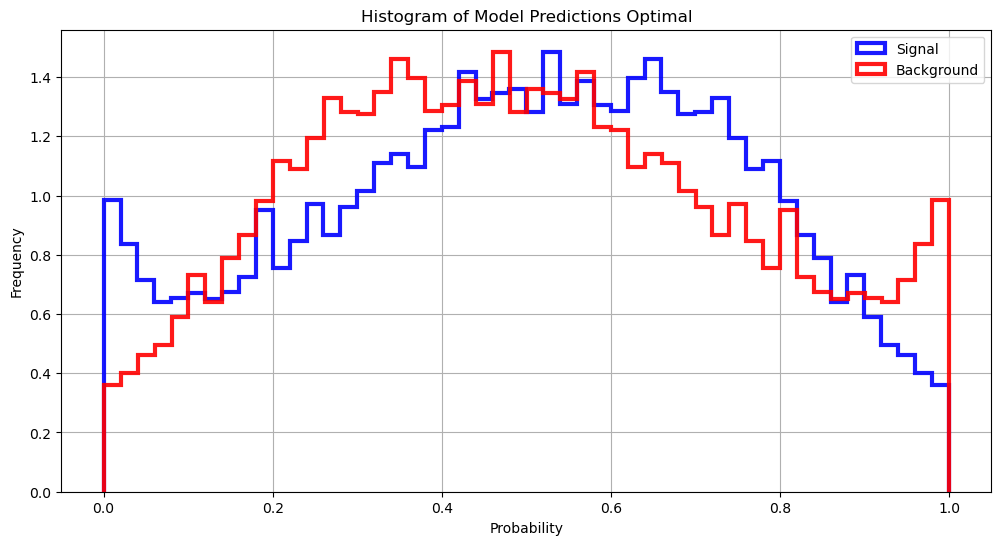

In [ ]:
models_opt = {'Optimal': model_opt,}
plot_loss(history_optimal)
plot_accuracy(history_optimal, 10)
plot_roc_curves_lowhigh(models_opt, [X_val_full], y_val, 10)
plot_prediction_histogram_lowhigh('Optimal', models_opt, [X_val_full], y_val)